In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries
from scipy import ndimage as ndi
import pandas as pd
import json
import os
import timeit
import random

In [2]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    from matplotlib import pyplot as plt
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(nRows, nCols)
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20,20))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        
        plt.subplot(nRows, nCols,i+1)
        
        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')
        
    plt.show()

In [3]:
def morphology(Mask, Size):
    from skimage.morphology import erosion, dilation, opening, closing, white_tophat
    from skimage.morphology import disk
    selem = disk(abs(Size))
    if(Size > 0):
        result = dilation(Mask, selem)
    else:
        result = erosion(Mask, selem)
    return result

In [4]:
import os
import pandas as pd

def get_subfiles(dir):
    ''' Get a list of immediate subfiles '''
    return next(os.walk(dir))[2]

In [5]:
def SegmentColorImageByMask(IM, Mask):
    Mask = Mask.astype(np.uint8)
    result = cv2.bitwise_and(IM, IM, mask = Mask)
    return result

In [6]:
def SegmentationByOtsu(image, mask):
    image_process = image.copy()
    image_mask = mask.copy()
    
    image_process[image_mask == 0] = 0
    ListPixel = image_process.ravel()
    ListPixel = ListPixel[ListPixel > 0]
    
    from skimage.filters import threshold_otsu
    otsu_thresh = threshold_otsu(ListPixel)
    
    return otsu_thresh

In [7]:
def ResizeImage(IM, DesiredWidth, DesiredHeight):
    from skimage.transform import rescale, resize
    
    OrigWidth = float(IM.shape[1])
    OrigHeight = float(IM.shape[0])
    Width = DesiredWidth
    Height = DesiredHeight
    
    if((Width == 0) & (Height == 0)):
        return IM
    
    if(Width == 0):
        Width = int((OrigWidth * Height)/OrigHeight)
        
    if(Height == 0):
        Height = int((OrigHeight * Width)/OrigWidth)
    dim = (Width, Height)
    # print(dim)
    resizedIM = cv2.resize(IM, dim, interpolation = cv2.INTER_NEAREST)
    # imshows([IM, resizedIM], ["Image", "resizedIM"],1,2)
    return resizedIM

In [8]:
def SegmentByKmeans(image_orig, nClusters = 3):
    img = image_orig.copy()
    Z = img.reshape((-1,3))
    
    # convert to np.float32
    Z = np.float32(Z)
    
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
    K = nClusters
    ret,labellist,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[labellist.flatten()]
    res2 = res.reshape((img.shape))
    label2 = labellist.reshape((img.shape[:2]))
    
    image_index = label2
    image_kmeans = res2
    
    # Sort to make sure the index is stable
    AreaList = []
    for idx in range(image_index.max() + 1):
        mask = image_index == idx
        AreaList.append(mask.sum().sum())
    
    sort_index = np.argsort(AreaList)[::-1]
    index = 0
    image_index1 = image_index * 0
    for idx in sort_index:
        image_index1[image_index == idx] = index
        index = index + 1
    
    image_index = image_index1.copy()
    
    return image_index, image_kmeans

In [9]:
def LabelObjectByMask(image_input, image_mask, type = "BBox", color = (0,255,0), thick = 2):
    image_input = image_orig.copy()
    image_output = image_input.copy()
    
    label_img = label(image_mask)
    regions = regionprops(label_img)
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        left_top = (minc, minr)
        right_bottom = (maxc, maxr)
        at_row, at_col = props.centroid
        
        if(type == "Center"):
            cv2.drawMarker(image_output, (int(at_col), int(at_row)),color, markerType=cv2.MARKER_STAR, markerSize=15, thickness= 1, line_type=cv2.LINE_AA)
        if(type == "BBox"):
            cv2.rectangle(image_output,left_top, right_bottom, color ,thick)
        
    if(type == "Boundary"):
        color = [(number / 255) for number in color]
        image_mask = morphology(image_mask, 1)
        image_output = mark_boundaries(image_output, image_mask, color = color, mode='thick')
    if(type == "Fill"):
        image_output[image_mask > 0] = color
        
    return image_output

In [10]:
def SelectMaskByThreshArea(Mask, minArea = 300, maxArea = 100000):
    import pandas as pd
    from skimage.measure import label, regionprops
    mask = Mask.copy()
    mask_output = mask * 0
    
    bboxList = []
    label_img = label(mask)
    regions = regionprops(label_img)
    for props in regions:
        area = props.area
        label = props.label
        if((area > minArea) and (area < maxArea)):
            mask_output = mask_output + (label_img == label).astype(int)
    return mask_output

In [11]:
def load_image(file_name):
    idx = SegDataName.index(file_name)
    print("Selected Image : ", "\nIndex ", idx, "\nName ", SegDataName[idx])
    image = SegDataIMG[idx]
    image_orig = ResizeImage(image, DesiredWidth = 0, DesiredHeight = 350)
    image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    return [image_orig, image_gray, image_hsv, image_ycbcr]

In [12]:
def get_mask(image_orig, image_gray, nClusters, minArea, maxArea):
    image_index, image_kmeans = SegmentByKmeans(image_orig, nClusters = nClusters)
    mask_list = []
    mask_abnormal = image_gray * 0
    for idx in range(image_index.max() + 1):
        imask = image_index == idx
        mask_small = SelectMaskByThreshArea(imask, minArea = minArea, maxArea = maxArea)
        mask_list.append(imask)
        mask_abnormal = mask_abnormal + mask_small
    return [image_index, image_kmeans, mask_list, mask_abnormal]

In [13]:
def get_detectd_images(list_images, nClusters, imask, minArea, maxArea, area_condition, imean_condition):
    image_orig, image_gray, image_hsv, image_ycbcr = list_images
    
    h = image_hsv[:,:,0]
    s = image_hsv[:,:,1]
    v = image_hsv[:,:,2]
    y = image_ycbcr[:,:,0]
    cb = image_ycbcr[:,:,1]
    cr = image_ycbcr[:,:,2]
    
    image_index, image_kmeans, mask_list, mask_abnormal = \
                            get_mask(image_orig, image_gray, nClusters, minArea, maxArea)
    
    label_img = label(imask)
    regions = regionprops(label_img, intensity_image = image_hsv[:,:,0])

    mask_condition = mask_abnormal * 0
    for props in regions:
        area = props.area
        ilabel = props.label
        imask = label_img == ilabel
        imean = props.mean_intensity
        imax = props.max_intensity
        imin = props.min_intensity
        
        result_area_cond = []
        for cond in area_condition:
            result_area_cond.append(area > cond[0] and area < cond[1])
        condition = result_area_cond[0]
        if len(result_area_cond) > 1:
            for res in result_area_cond[1:]:
                condition = condition or res
                
        result_imean_cond = []
        for cond in imean_condition:
            result_imean_cond.append(imean >= cond[0] and imean <= cond[1])
        condition2 = result_imean_cond[0]
        if len(result_imean_cond) > 1:
            for res in result_imean_cond[1:]:
                condition2 = condition2 or res
                
        condition1 = condition and condition2
        
        if(condition1):
            mask_condition = mask_condition + (imask).astype(int)

    image_output1 = LabelObjectByMask(image_orig, mask_condition, type = "Fill", color = (0,255,0), thick = 2)
    image_output2 = LabelObjectByMask(image_orig, mask_condition, type = "BBox", color = (0,255,0), thick = 2)
    image_output3 = LabelObjectByMask(image_orig, mask_condition, type = "Center", color = (0,255,0), thick = 2)
    image_output4 = LabelObjectByMask(image_orig, mask_condition, type = "Boundary", color = (0,255,0), thick = 2)
    
    return [image_output1, image_output2, image_output3, image_output4]

In [14]:
path_data = '/home/dinh_anh_huy/GitHub/2020-2021/semester-1/digital-image-processing/lab-06/Lab06 - Image/'

path = path_data
all_names = get_subfiles(path)
print("Number of Images:", len(all_names))
IMG = []
for i in range(len(all_names)):
    tmp = cv2.imread(path + all_names[i])
    IMG.append(tmp)
    
SegDataIMG = IMG.copy()
SegDataName = all_names

Number of Images: 60


## Vết Defect A

Selected Image :  
Index  14 
Name  DefectA 03.bmp


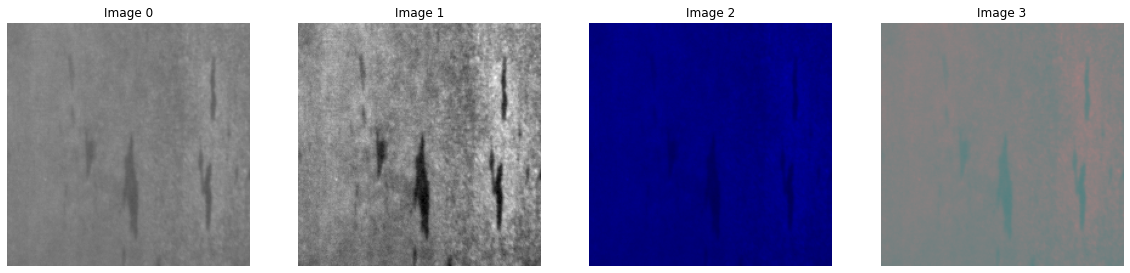

In [15]:
image_orig, image_gray, image_hsv, image_ycbcr = load_image('DefectA 03.bmp')
ShowImage([image_orig, image_gray, image_hsv, image_ycbcr], 1, 4)

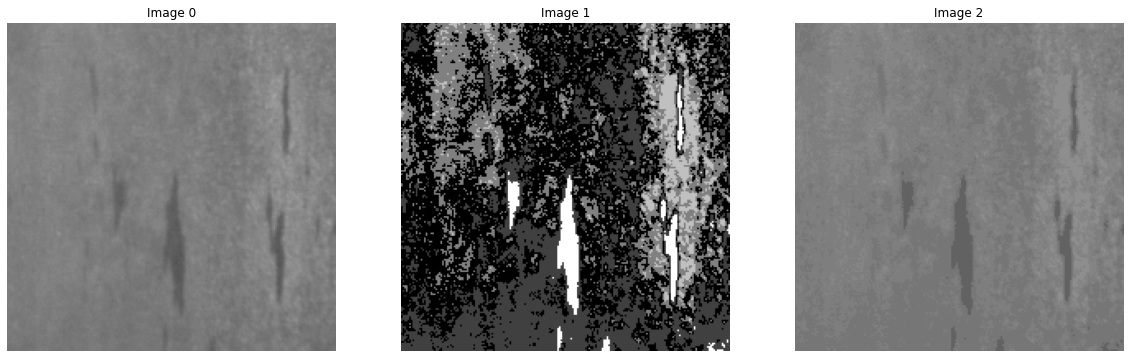

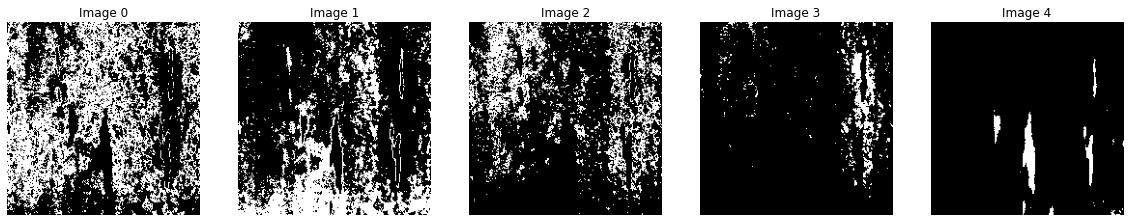

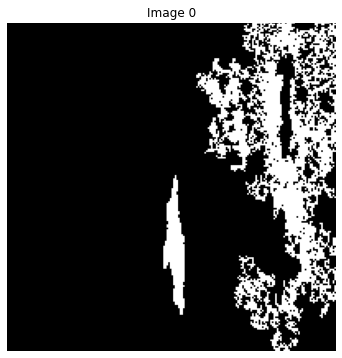

In [16]:
image_index, image_kmeans, mask_list, mask_abnormal = get_mask(image_orig, image_gray, 5, 500, 2000)
ShowImage([image_orig, image_index, image_kmeans], 1, 3)
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

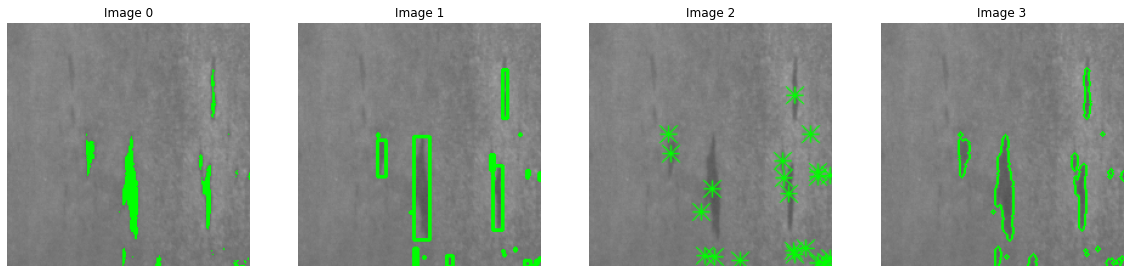

In [17]:
list_images = [image_orig, image_gray, image_hsv, image_ycbcr]
nClusters = 5
imask = image_index == 4
minArea = 500
maxArea = 2000
area_condition = [[0, 20000]]
max_imean = [[0, 70]]
[image_output1, image_output2, image_output3, image_output4] = get_detectd_images(list_images, nClusters, imask, minArea, maxArea, area_condition, max_imean)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

## Vết Defect B

Selected Image :  
Index  54 
Name  DefectB 04.bmp


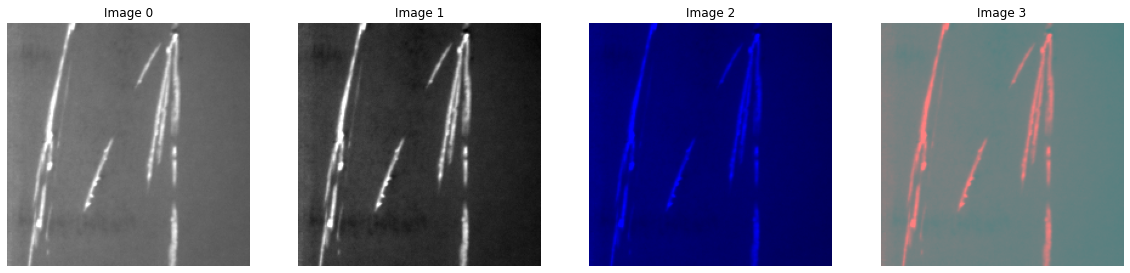

In [18]:
image_orig, image_gray, image_hsv, image_ycbcr = load_image('DefectB 04.bmp')
ShowImage([image_orig, image_gray, image_hsv, image_ycbcr], 1, 4)

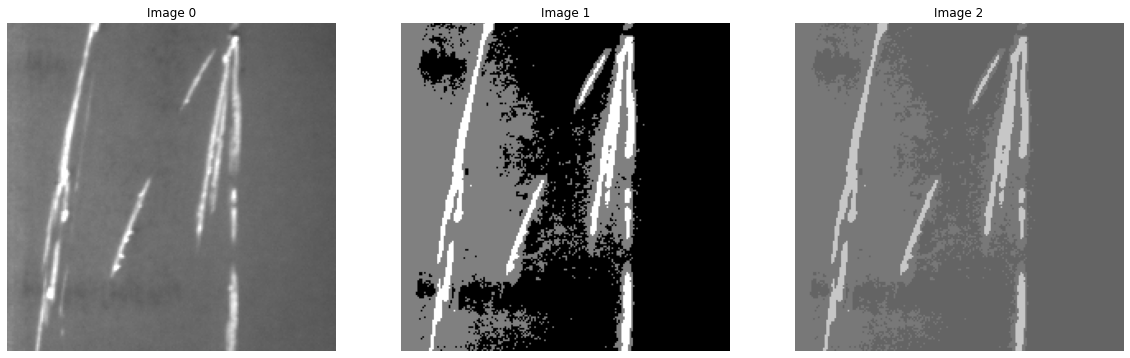

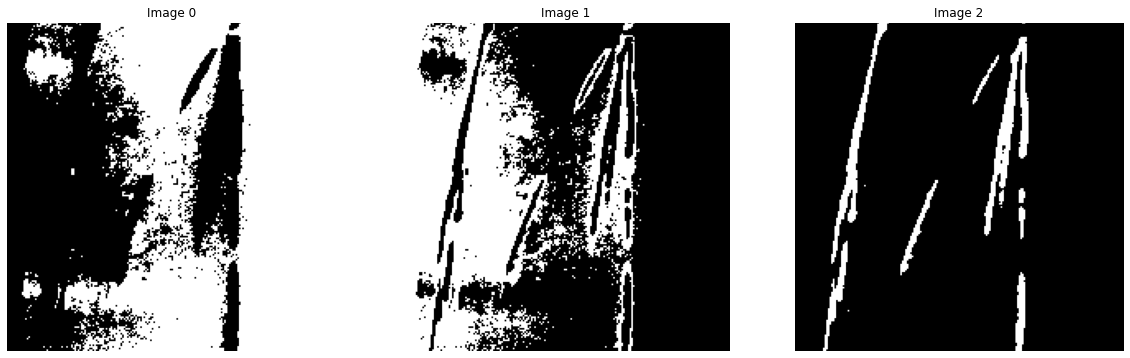

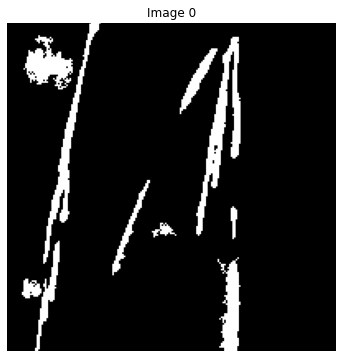

In [19]:
nClusters = 3
minArea = 50
maxArea = 1500
image_index, image_kmeans, mask_list, mask_abnormal = get_mask(image_orig, image_gray, nClusters, minArea, maxArea)
ShowImage([image_orig, image_index, image_kmeans], 1, 3)
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

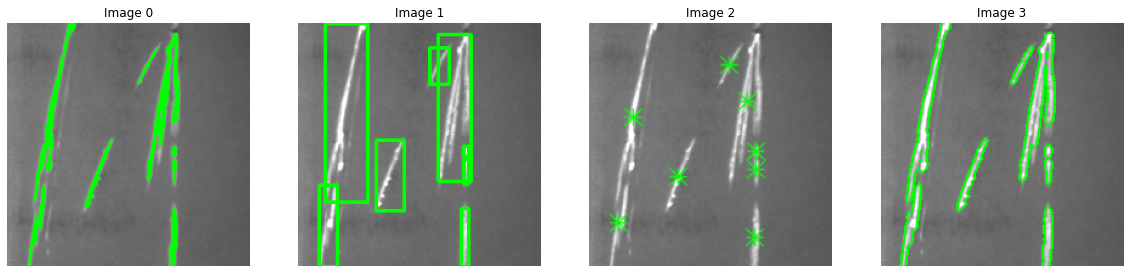

In [20]:
list_images = [image_orig, image_gray, image_hsv, image_ycbcr]
nClusters = 3
imask = image_index == 2
minArea = 25
maxArea = 1500
area_condition = [[25, 2000]] 
max_imean = [[0, 180]]
[image_output1, image_output2, image_output3, image_output4] = get_detectd_images(list_images, nClusters, imask, minArea, maxArea, area_condition, max_imean)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

## Biển số xe

Selected Image :  
Index  0 
Name  DrivingPlate 04.jpg


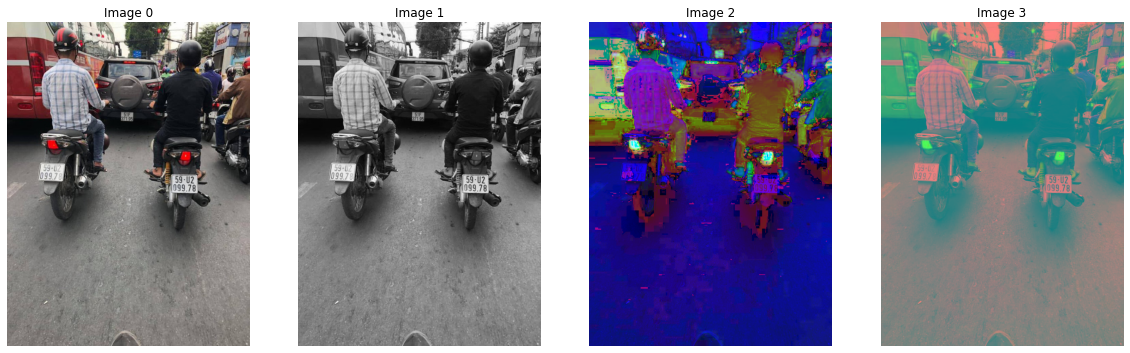

In [21]:
image_orig, image_gray, image_hsv, image_ycbcr = load_image('DrivingPlate 04.jpg')
ShowImage([image_orig, image_gray, image_hsv, image_ycbcr], 1, 4)

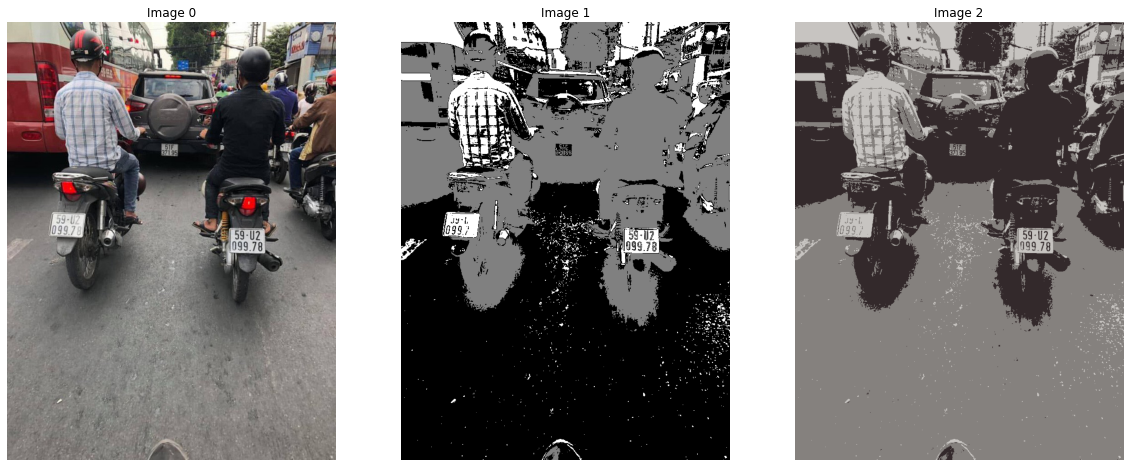

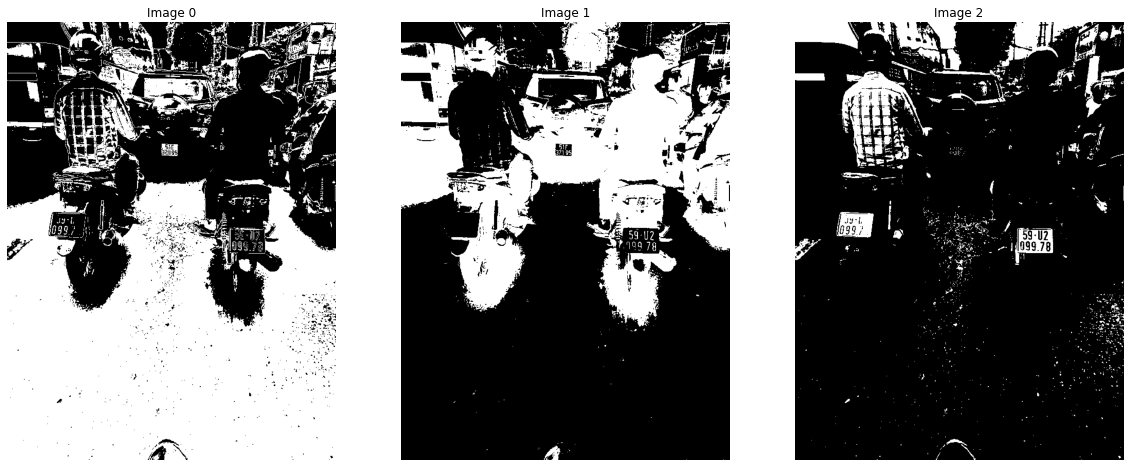

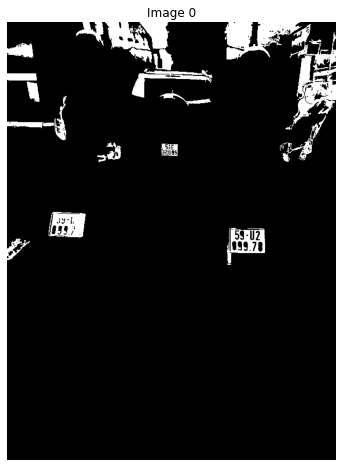

In [22]:
nClusters = 3
minArea = 500
maxArea = 4000
image_index, image_kmeans, mask_list, mask_abnormal = get_mask(image_orig, image_gray, nClusters, minArea, maxArea)
ShowImage([image_orig, image_index, image_kmeans], 1, 3)
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

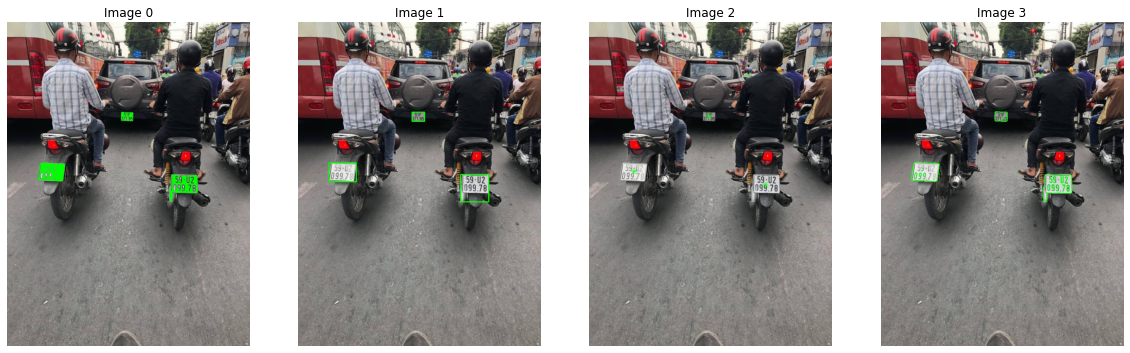

In [23]:
list_images = [image_orig, image_gray, image_hsv, image_ycbcr]
nClusters = 3
imask = mask_abnormal
minArea = 400
maxArea = 4000
area_condition = [[500, 510], [2600, 2620], [2380, 2390]] 
max_imean = [[0,180]]
[image_output1, image_output2, image_output3, image_output4] = get_detectd_images(list_images, nClusters, imask, minArea, maxArea, area_condition, max_imean)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

## Vết xuất huyết và xuất tiết

Selected Image :  
Index  46 
Name  Eye 04.jpg


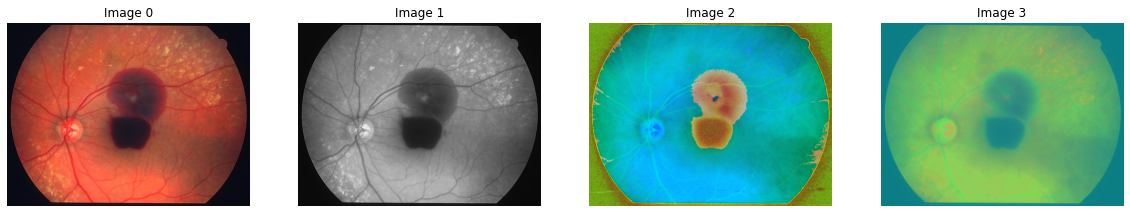

In [24]:
image_orig, image_gray, image_hsv, image_ycbcr = load_image('Eye 04.jpg')
ShowImage([image_orig, image_gray, image_hsv, image_ycbcr], 1, 4)

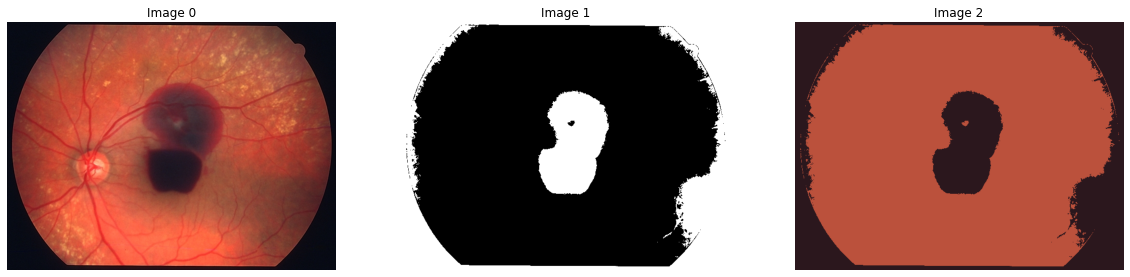

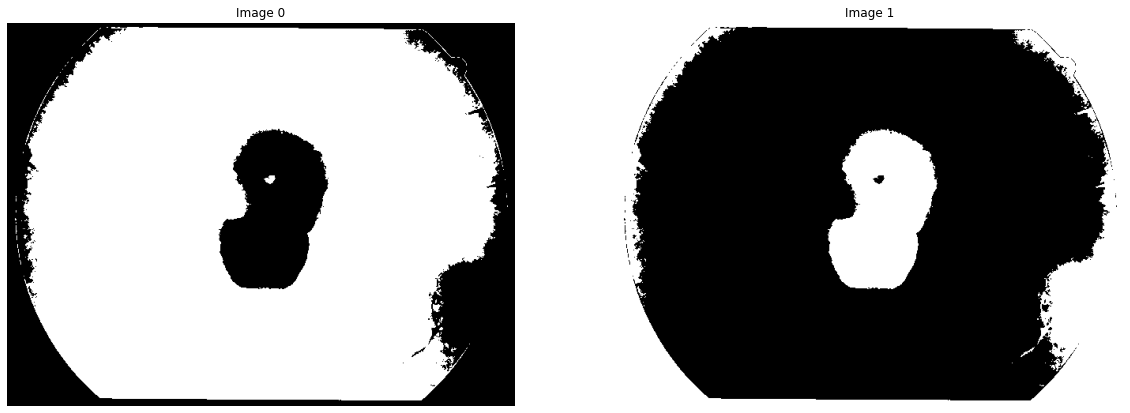

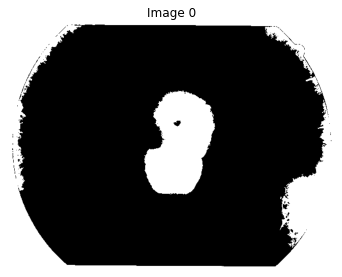

In [25]:
nClusters = 2
minArea = 500
maxArea = 200000
image_index, image_kmeans, mask_list, mask_abnormal = get_mask(image_orig, image_gray, nClusters, minArea, maxArea)
ShowImage([image_orig, image_index, image_kmeans], 1, 3)
ShowImage(mask_list, 1, len(mask_list))
ShowImage([mask_abnormal], 1, 3)

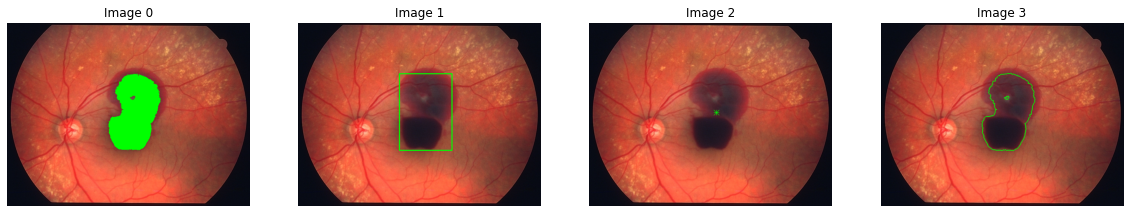

In [26]:
list_images = [image_orig, image_gray, image_hsv, image_ycbcr]
nClusters = 2
imask = mask_abnormal
minArea = 500
maxArea = 200000
area_condition = [[19000, 20000]] 
max_imean = [[0, 180]]
[image_output1, image_output2, image_output3, image_output4] = get_detectd_images(list_images, nClusters, imask, minArea, maxArea, area_condition, max_imean)
ShowImage([image_output1, image_output2, image_output3, image_output4], 1, 4)

## Khuôn mặt người

Selected Image :  
Index  55 
Name  Face 04.jpg


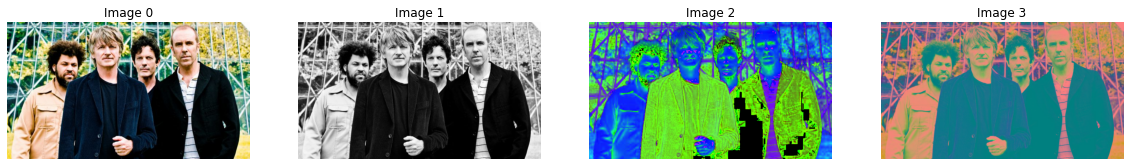

In [131]:
image_orig, image_gray, image_hsv, image_ycbcr = load_image('Face 04.jpg')
ShowImage([image_orig, image_gray, image_hsv, image_ycbcr], 1, 4)

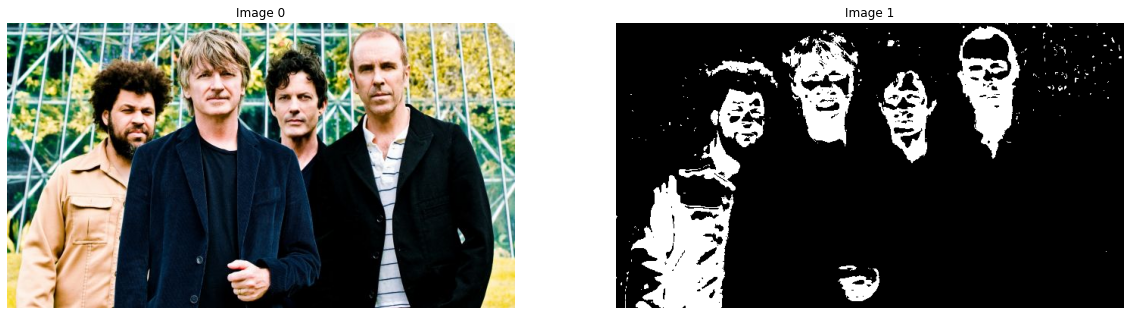

In [132]:
lower = np.array([0, 50, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")
skinMask = cv2.inRange(image_hsv, lower, upper)
ShowImage([image_orig, skinMask], 1, 2)

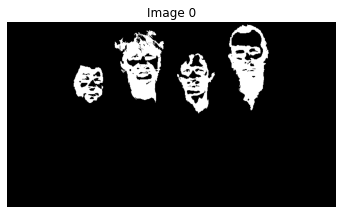

In [133]:
mask_abnormal = image_gray * 0
mask_small = SelectMaskByThreshArea(skinMask, minArea = 2000, maxArea = 10000)
mask_abnormal = mask_abnormal + mask_small
ShowImage([mask_abnormal], 1, 3)

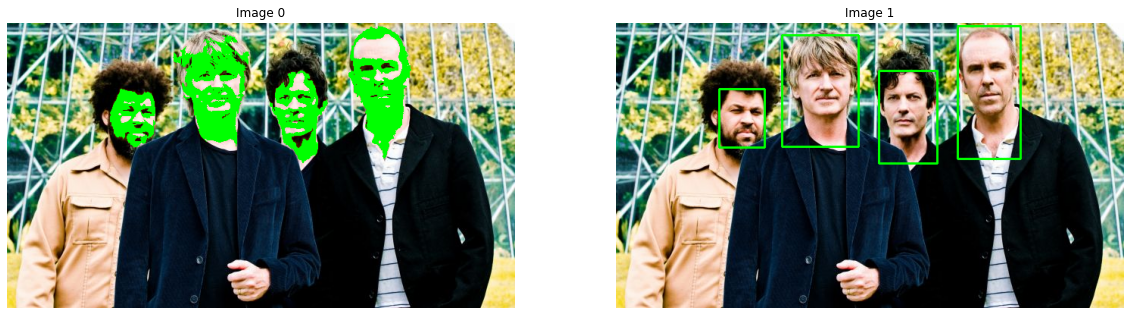

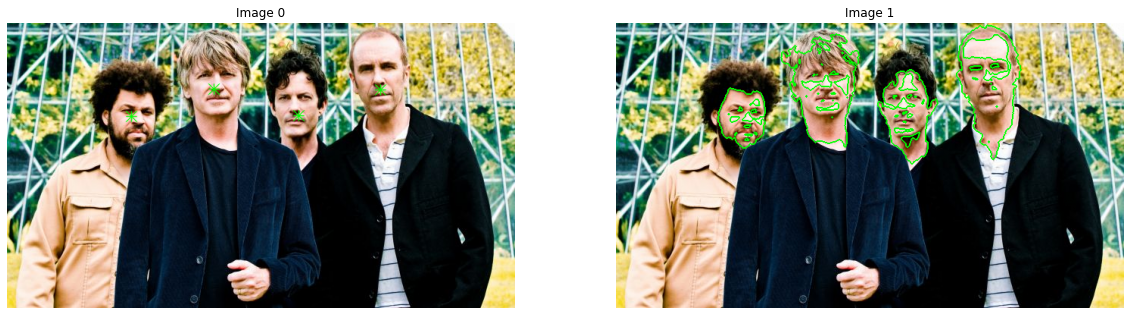

In [135]:
h = image_hsv[:,:,0]
s = image_hsv[:,:,1]
v = image_hsv[:,:,2]
y = image_ycbcr[:,:,0]
cb = image_ycbcr[:,:,1]
cr = image_ycbcr[:,:,2]

label_img = label(skinMask)
regions = regionprops(label_img, intensity_image = image_hsv[:,:,0])

mask_condition = mask_abnormal * 0
for props in regions:
    area = props.area
    ilabel = props.label
    imask = label_img == ilabel
    imean = props.mean_intensity
    imax = props.max_intensity
    imin = props.min_intensity
    condition1 = (area > 2700) and (area < 7200) and (imean < 70)

    if(condition1):
        mask_condition = mask_condition + (imask).astype(int)
        
image_output1 = LabelObjectByMask(image_orig, mask_abnormal, type = "Fill", color = (0,255,0), thick = 2)
image_output2 = LabelObjectByMask(image_orig, mask_abnormal, type = "BBox", color = (0,255,0), thick = 2)
image_output3 = LabelObjectByMask(image_orig, mask_abnormal, type = "Center", color = (0,255,0), thick = 2)
image_output4 = LabelObjectByMask(image_orig, mask_abnormal, type = "Boundary", color = (0,255,0), thick = 2)

ShowImage([image_output1, image_output2], 1, 2)
ShowImage([image_output3, image_output4], 1, 2)

In [115]:
# # imask = image_index == 1
# imask = mask_abnormal
# label_img = label(imask)
# regions = regionprops(label_img, intensity_image = image_hsv[:,:,0])
# for props in regions:
#         area = props.area
#         ilabel = props.label
#         imask = label_img == ilabel
#         imean = props.mean_intensity
#         imax = props.max_intensity
#         imin = props.min_intensity
#         ratewh = width/height
#         rateArea = area/ (width * height)
#         if (area > 500 and area < 100000): #or (area > 2600 and area < 2620) or (area > 2380 and area < 2390):
#             print(area, ratewh, rateArea)      # in ra diện tích của vết 
#             plt.imshow(imask, cmap = plt.cm.gray)
#             plt.show()

## Lửa